# Closed-Form Bounds for DP-SGD against Record-level Inference

This notebook enables reproducing Figures 2-7 from our paper.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
from scipy import integrate
from scipy.special import erfinv

from libbayessgd import *

FIGSIZE = (4, 4/1.6)
DPI = 300
LS = ["-", "--", "-.", ":"]

## Figure 2: When is approximation of mixture to Gaussian a good approximation?

We evaluate this via numerical integration, and compare this with our bound (Proposition 4).

In [2]:
def setup_distributions(mu, sigma, w):
    sigma = sigma*mu

    p = lambda x: norm.pdf(x, mu*w, sigma)
    q1 = lambda x: norm.pdf(x, mu, sigma)
    q2 = lambda x: norm.pdf(x, 0, sigma)
    q = lambda x: w*q1(x) + (1-w)*q2(x)
    
    return p, q

def tv_by_integration(p, q):
    return .5*integrate.quad(lambda x: np.abs(p(x)-q(x)), -np.inf, np.inf)[0]

In [3]:
repeat = 10
mu = 1 # The bound doesn't depend on this parameter.
res = []
for sigma in tqdm(np.logspace(-1, 2, repeat)):
    for w in np.logspace(-5, -1, repeat):
        p, q = setup_distributions(mu, sigma, w)
        res.append({"sigma": sigma, "sample_rate": w, "tv": tv_by_integration(p, q)})

res = pd.DataFrame(res)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


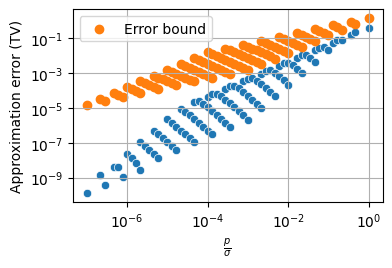

In [4]:
res["ratio"] = res.sample_rate/res.sigma

plt.figure(figsize=FIGSIZE)
sns.scatterplot(data=res, x="ratio", y="tv")
plt.scatter(res["ratio"], tv_error_term(p=res["sample_rate"], sigma=res["sigma"], T=1), label="Error bound")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\frac{p}{\sigma}$")
plt.ylabel("Approximation error (TV)")
plt.grid()
plt.legend()

# Membership inference

### Figure 3

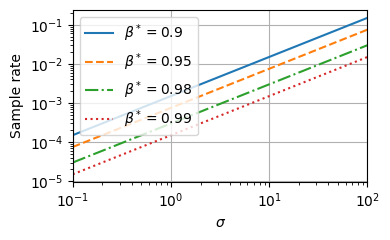

In [5]:
target_T = 20*347
sigma_range = np.logspace(-1, 2, 10)

plt.figure(figsize=FIGSIZE)
for i, target_beta in enumerate([0.9, 0.95, 0.98, 0.99]):
    c = erfinv(1-target_beta)*np.sqrt(2)/np.sqrt(target_T)
    plt.plot(sigma_range, sigma_range*c, label=f"$\\beta^*={target_beta}$", ls=LS[i])
plt.ylabel("Sample rate")
plt.xlabel(r"$\sigma$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlim([min(sigma_range), max(sigma_range)])
plt.tight_layout()

### Numbers reported in the paper:

In [6]:
target_beta = 0.98
target_t = 5000
erfinv(1-target_beta)*np.sqrt(2)/np.sqrt(target_t)

0.00035452790053356074

This plot wasn't included in the paper due to space constraints. It shows how Bayes security varies
w.r.t. the choice of $\sigma$ and $T$:

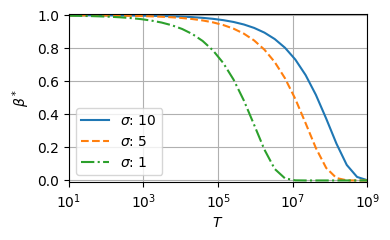

In [7]:
N = 100000
L = int(N*0.001)
Trange = np.logspace(1, 9, 30, dtype=int)

plt.figure(figsize=FIGSIZE)
for i, sigma in enumerate([10, 5, 1]):
    plt.plot(Trange, compute_beta_mia(L/N, sigma, Trange), label=f"$\sigma$: {sigma}", ls=LS[i])

plt.xscale("log")
plt.xlabel("$T$")
plt.ylabel(r"$\beta^*$")
plt.legend()
plt.grid()
plt.xlim([10, max(Trange)])
plt.ylim([-0.01, 1.01])
plt.tight_layout()

Choosing parameters for Adult and Purchase

In [8]:
# Adult
N = 26048
L = 256
n_steps_per_epoch = int(N/L)
target_beta = 0.90
target_epoch = 20
target_t = target_epoch*n_steps_per_epoch

c = erfinv(1-target_beta)*np.sqrt(2)/np.sqrt(target_t)
f"Sigma should be: {L/N/c}"

'Sigma should be: 3.5151151512784575'

In [9]:
# Purchase
N = 197324
L = 512
n_steps_per_epoch = int(N/L)
target_beta = 0.90
target_epoch = 20
target_t = target_epoch*n_steps_per_epoch

c = erfinv(1-target_beta)*np.sqrt(2)/np.sqrt(target_t)
f"Sigma should be: {L/N/c}"

'Sigma should be: 1.8118978212546515'

### Figure 4: comparison with PLD

In [10]:
results = []

for epochs in [1] + list(range(10, 101, 10)):
    for sigma in [0.5, 1, 2, 3, 4, 5, 10]:
        for p in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
            try:
                accountant_result = np.clip(compute_beta_pld(p=p, sigma=sigma, T=int(epochs/p), relation="s"), 0, 1)
            except ValueError:
                print(f"Accountant failed for parameters: sigma={sigma}, p={p}")
            results.append({
                "sigma": sigma,
                "p": p,
                "epochs": epochs,
                "estimate": compute_beta_mia(p=p, sigma=sigma, T=int(epochs/p), relation="s"),
                "accountant": accountant_result
            })

results = pd.DataFrame(results)

/home/gcherubin/.virtualenvs/opacusdpsgd/lib/python3.9/site-packages/fourier_accountant/common.py:156: RuntimeWarning: overflow encountered in power
  F_prod = F_prod * FF1**ncomp
/home/gcherubin/.virtualenvs/opacusdpsgd/lib/python3.9/site-packages/fourier_accountant/common.py:156: RuntimeWarning: invalid value encountered in multiply
  F_prod = F_prod * FF1**ncomp


Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sigma=0.5, p=0.0001
Accountant failed for parameters: sigma=10, p=0.0001
Accountant failed for parameters: sig

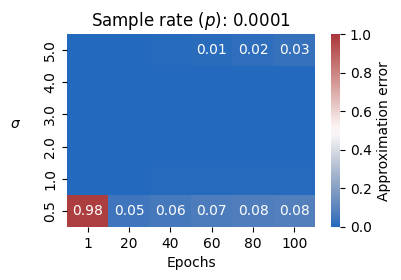

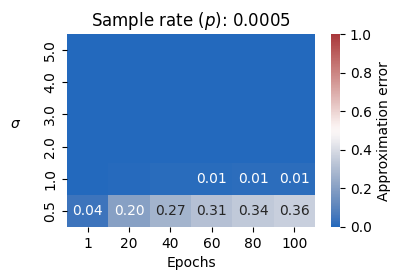

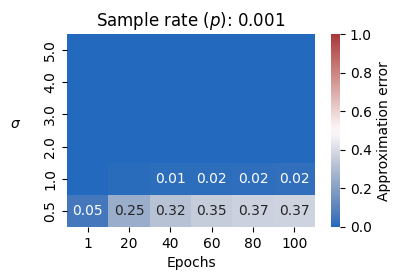

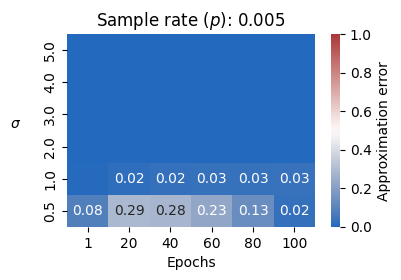

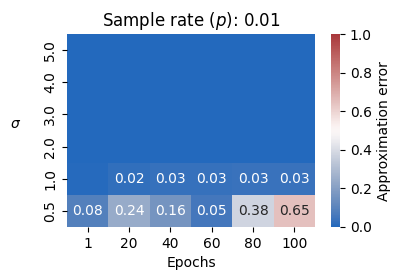

In [11]:
results["error"] = abs(results.estimate - results.accountant)

for p in np.unique(results.p):
    plt.figure(figsize=FIGSIZE)
    plt.title(f"Sample rate ($p$): {p}")
    
    # Clearer plot.
    select_results = (results.p==p) & (results.sigma <= 5) & (((results.epochs % 20) == 0) | (results.epochs == 1))
    data = results[select_results].pivot(index="sigma", columns="epochs", values="error")

    # Label only if above threshold.
    threshold = 0.01
    labels = data.applymap(lambda x: f"{x:.2f}" if x > threshold else "")

    ax = sns.heatmap(data, annot=labels, fmt="", cmap=sns.color_palette("vlag", as_cmap=True), vmin=0, vmax=1)
    ax.invert_yaxis()
    # Labels.
    ax.set_xlabel("Epochs")
    ax.set_ylabel(r"$\sigma$", rotation=0, labelpad=20)
    # Label of color map.
    ax.collections[0].colorbar.set_label("Approximation error")

### Figure 7: TPR/FPR tradeoff

beta = 0.9716541071581478


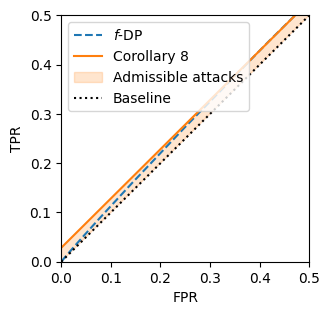

In [2]:
L = 1
C = 1 # Used by accountants.
N = 10_000
T = N*50
sigma = 2

plt.figure(figsize=(3.2, 3.2))
fprs_pld, tprs_pld = pld_tpr_fpr(N, L, sigma, T)
# Sort by fprs before plotting.
fprs_pld, tprs_pld = zip(*sorted(zip(fprs_pld, tprs_pld), key=lambda x: x[0]))
plt.plot(fprs_pld, tprs_pld, label=r"$f$-DP", color=sns.color_palette()[0], ls="--")

beta = compute_beta_pld(L/N, sigma, T, relation="s")
print(f"beta = {beta}")
tprs_beta = 1 + np.array(fprs_pld) - beta
plt.plot(fprs_pld, tprs_beta, label="Corollary 8", color=sns.color_palette()[1])

# Fill between tprs_beta and baseline.
plt.fill_between(fprs_pld, fprs_pld, tprs_beta, color=sns.color_palette()[1], alpha=0.2,
                 label="Admissible attacks")

# Baseline.
plt.plot([0, 1], [0, 1], label="Baseline", color="black", ls=":")

plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

Attacker aiming for a specific FPR level.
**This takes long to compute, as we run PLD with a very fine-grained grid for deltas.**

In [3]:
fprs_pld, tprs_pld = pld_tpr_fpr(N, L, sigma, T, deltas=np.logspace(-6, 0, 1000, endpoint=False)) # More fine-grained.

for fpr in [0.1, 0.05, 0.01]:
    # Closest PLD FPR to fpr.
    idx = np.argmin(np.abs(np.array(fprs_pld) - fpr))
    print(f"Beta* estimate for {fpr*100}% FPR: TPR = {1+fpr-beta}. The true risk is approximately TPR = {tprs_pld[idx]} (which corresponds to FPR = {fprs_pld[idx]}).")

Beta* estimate for 10.0% FPR: TPR = 0.12834589284185227. The true risk is approximately TPR = 0.11317232200683291 (which corresponds to FPR = 0.10011306760661427).
Beta* estimate for 5.0% FPR: TPR = 0.07834589284185223. The true risk is approximately TPR = 0.05753123469955934 (which corresponds to FPR = 0.04978728481417827).
Beta* estimate for 1.0% FPR: TPR = 0.03834589284185219. The true risk is approximately TPR = 0.012078055695730838 (which corresponds to FPR = 0.01001686223453741).


### Figure 5: Computational time comparison

In [169]:
sigma = 5
p = 0.001

pld_time = []
bayessgd_time = []
for i in tqdm(range(10)):
    for epoch in [1] + list(range(10, 101, 10)):
        T = epoch/p
        start = time.time()
        compute_beta_pld(p=p, sigma=sigma, T=T, relation="s")
        pld_time.append({"e": epoch, "time": time.time()-start})
        start = time.time()
        compute_beta_mia(p=p, sigma=sigma, T=T, relation="s")
        bayessgd_time.append({"e": epoch, "time": time.time()-start})

pld_time = pd.DataFrame(pld_time)
bayessgd_time = pd.DataFrame(bayessgd_time)

100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


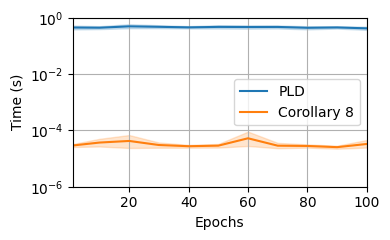

In [178]:
plt.figure(figsize=FIGSIZE)
sns.lineplot(pld_time, x="e", y="time", label="PLD")
sns.lineplot(bayessgd_time, x="e", y="time", label="Corollary 8")

plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.xlim([1, 100])
plt.ylim([1e-6, 1])
plt.legend()
plt.grid()

### Figure 6: Comparison with $(\varepsilon, \delta)$ and Advantage via inequality by Humphries et al.

In [4]:
import fourier_accountant

In [5]:
def compute_advantage_delta_humphries(p, sigma, T, epsilon):
    """Uses accountant + bound by Humphries et al. to compute (MIA advantage, delta).
    """
    delta = fourier_accountant.get_delta_S(target_eps=epsilon, sigma=sigma, q=p, ncomp=int(T), nx=1e6)
    delta = max(delta, 0) # For numerical errors, PLD sometimes returns a negative delta.
    
    adv = (np.exp(epsilon)-1+2*delta)/(np.exp(epsilon)+1)
    
    return 1-adv, delta

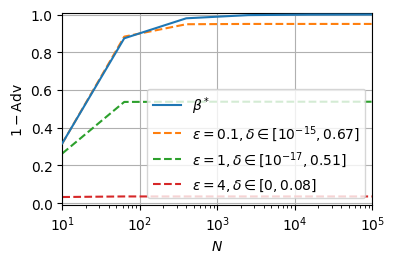

In [13]:
Nrange = np.logspace(1, 5, 6, dtype=int)
L = 10
sigma = 1
T = 1

plt.figure(figsize=FIGSIZE)
line = plt.plot(Nrange, compute_beta_mia(p=L/Nrange, sigma=sigma, T=T), label=r"$\beta^*$", ls="-")

for eps in [0.1, 1, 4]:
    adv_complement, deltas = zip(*[compute_advantage_delta_humphries(p=L/N, sigma=sigma, T=T, epsilon=eps) for N in Nrange])
    # Just show the order of magnitude of the deltas, to make the legend easier to read.
    if min(deltas) > 0:
        min_delta = f"10^{{{int(np.log10(min(deltas)))}}}"
    else:
        min_delta = "0"
    plt.plot(Nrange, adv_complement, label=f"$\\varepsilon={eps}, \delta\in[{min_delta}, {max(deltas):.2f}]$", ls="--")

line[0].set_zorder(3)

plt.xscale("log")
plt.xlabel("$N$")
plt.ylabel(r"$1-\mathrm{Adv}$")
plt.legend(loc="lower right")
plt.grid()
plt.xlim([10, max(Nrange)])
plt.ylim([-0.01, 1.01])

Using our bound as an approximate $(\varepsilon, \delta)$-DP estimator. Please refer to the discussion in our paper about why this can only give very approximate estimates.

In [29]:
sigma = 2
L = 1
N = 10000
T = 30*N/L
delta = 1/N**2

# Estimate epsilon via PLD.
accountant_epsilon = fourier_accountant.get_epsilon_S(target_delta=delta, sigma=sigma, q=L/N, ncomp=T)

# Estimate epsilon via our bound.
beta_to_eps = lambda beta, delta: np.log(-(2*delta+beta-2)/beta)
beta = compute_beta_mia(p=L/N, sigma=sigma, T=T)
beta_epsilon = beta_to_eps(beta, delta)


print(f"Accountant estimate: eps>={accountant_epsilon}, beta*-based estimate: eps>={beta_epsilon}")

Accountant estimate: eps>=0.2638868531958128, beta*-based estimate: eps>=0.04370341028734318
